- functioning NMT model
- attention model using classes
- bi-directional LSTMs in Encoder
- training works – loss goes down after 5 epochs
- pre-trained embeddings incorporated
- Using @tf.function wrapper, which speeds up training immensely

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Concatenate, LSTM, Embedding, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

#import plotly.graph_objects as go


In [92]:
from google.colab import drive
drive.mount('/content/gdrive')

df_en_de = pd.read_table('/content/gdrive/MyDrive/deu-eng/deu.txt', names=['eng', 'deu', 'attr'])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [93]:
#df_en_de = pd.read_table('deu-eng/deu.txt', names=['eng', 'deu', 'attr'])
df_en_de = df_en_de.drop('attr',axis = 1).rename(columns = {'eng':'english', 'deu':'german'})

In [94]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub("'", '', sentence)
    sentence = sentence.replace('ü', 'ue').replace('ä', 'ae').replace('ö', 'oe').replace('ß', 'ss')
    exclude = set(string.punctuation)
    sentence = ''.join(ch for ch in sentence if ch not in exclude)
    sentence = 'start_ ' + sentence + ' _end'
    sentence = sentence.encode("ascii", "ignore")
    sentence = sentence.decode()
    return sentence

In [95]:
pairs = df_en_de
pairs = pairs.sample(frac = 0.1)
pairs['english'] = pairs['english'].apply(preprocess_sentence)
pairs['german'] = pairs['german'].apply(preprocess_sentence)

In [96]:
source = pairs['english']
target = pairs ['german']

In [97]:
# create tokenizer & tensor for source and target
source_sentence_tokenizer= Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding='post' )

target_sentence_tokenizer= Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post' )

In [98]:
# Create word to index and index to word mappings for source and target

source_word_index = source_sentence_tokenizer.word_index
target_word_index = target_sentence_tokenizer.word_index

source_index_word = source_sentence_tokenizer.index_word
target_index_word = target_sentence_tokenizer.index_word

In [99]:
!python -m spacy download en_core_web_lg
import en_core_web_lg

!python -m spacy download de_core_news_sm
import de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.0 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [100]:
nlp_source = en_core_web_lg.load()
nlp_target = de_core_news_sm.load()

In [101]:
vocab_len_source = len(source_word_index.keys())
vocab_len_target = len(target_word_index.keys())
vocab_len_source, vocab_len_target


(7423, 12087)

In [102]:
num_tokens_source = vocab_len_source + 1
num_tokens_target = vocab_len_target + 1

In [103]:
# source language embedding dimensions
embedding_dim_source = len(nlp_source('The').vector)
# initialise embedding matrix for source language
embedding_matrix_source = np.zeros((num_tokens_source, embedding_dim_source))
for word, i in source_word_index.items():
    embedding_vector = nlp_source(word).vector
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_source[i] = embedding_vector

# target language embedding dimensions
embedding_dim_target = len(nlp_target('Der').vector)
# initialise embedding matrix for target language
embedding_matrix_target = np.zeros((num_tokens_target, embedding_dim_target))
for word, i in target_word_index.items():
    embedding_vector = nlp_target(word).vector
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_target[i] = embedding_vector

In [104]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor = train_test_split(
                                                                source_tensor, target_tensor,test_size=0.2
                                                                )

In [105]:
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [106]:
max_target_length, max_source_length

(75, 67)

In [107]:
BATCH_SIZE = 32
#Create data in memeory 
dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BATCH_SIZE)
# shuffles the data in the batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [108]:
source_batch, target_batch =next(iter(dataset))
print(source_batch.shape, target_batch.shape)
print(source_batch[1])

(32, 67) (32, 75)
tf.Tensor(
[  1 117  37   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(67,), dtype=int32)


In [109]:
BUFFER_SIZE = len(source_train_tensor)
steps_per_epoch= BUFFER_SIZE//BATCH_SIZE
embedding_dim= 256
units= 256
attention_layer_units = 100
source_vocab_size= len(source_sentence_tokenizer.word_index)+1
target_vocab_size= len(target_sentence_tokenizer.word_index)+1

In [110]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size = num_tokens_source, embedding_dim = embedding_dim_source, 
                    encoder_units = units, batch_size=BATCH_SIZE):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        self.embedding = Embedding(vocab_size, embedding_dim, 
                                    embeddings_initializer = Constant(embedding_matrix_source),
                                    trainable = False)
        self.lstm= Bidirectional(LSTM (encoder_units, 
                                      return_sequences=True,
                                      return_state=True,                                      
                                      recurrent_initializer='glorot_uniform'
                                     ))
    def call(self, x):
                                                                # x = (m, Tx)
                                                                # hidden = (m, encoder_units)
                                                                
        x = self.embedding(x)                                   # x = (m, Tx, embedding_dim)
        # pass input x through bi-directional LSTM
                                                                
        (enc_sequential, enc_forward_h, 
        enc_forward_c, enc_backward_h, enc_backward_c) = self.lstm(x)

        # concatenate forward and backward states
        enc_final_h = Concatenate()([enc_forward_h, enc_backward_h])
        enc_final_c = Concatenate()([enc_forward_c, enc_backward_c])

        return enc_sequential, enc_final_h, enc_final_c                     # enc_sequential = (m, Tx, 2 * encoder_units) 
                                                                            # enc_h = (m, 2 * encoder_units)
                                                                            # enc_c = (m, 2 * encoder_units)
    
    # def initialize_state(self):
    #     return tf.zeros((self.batch_size, self.encoder_units))
    

In [111]:
# check dimensions
encoder = Encoder(num_tokens_source, embedding_dim_source, units, BATCH_SIZE)

#initial_state = encoder.initialize_state()
enc_sequential, enc_final_h, enc_final_c = encoder(source_batch)

print (f'Encoder sequential: {enc_sequential.shape}')
print (f'Encoder final state_h: {enc_final_h.shape}')
print (f'Encoder final state_c: {enc_final_c.shape}')

Encoder sequential: (32, 67, 512)
Encoder final state_h: (32, 512)
Encoder final state_c: (32, 512)


In [112]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super( BahdanauAttention, self).__init__()
        self.W1= tf.keras.layers.Dense(units)  # decoder hidden (at time-step "t-1")
        self.W2= tf.keras.layers.Dense(units)  # encoder hidden (at time-step "t")
        self.V= tf.keras.layers.Dense(1)
    
    def call(self, dec_hidden, enc_hidden):
                                                                # dec_hidden = (m, 2*units) 
                                                                # enc_hidden:   (m, Tx, 2*units)

        dec_hidden_with_time = tf.expand_dims(dec_hidden, 1)    # dec_hidden_with_time = (m, 1, 2*units)
        
                                                                
        # W1() = (m, 1, 10) 
        # W2() = (m, Tx, 10)
        # Broadcasting happens when you add
        # W1() + W2 () = (m, Tx, 10)

        score = self.V(tf.nn.tanh(self.W1(dec_hidden_with_time) + self.W2(enc_hidden))) # (m, Tx, 1)
        
        # normalise scores with softmax
        attention_weights = tf.nn.softmax(score, axis=1)                                # (m, Tx, 1)
        
        # apply each weight to encoder hidden state at respective time-step 
        context_vector= attention_weights * enc_hidden                                  # (m, Tx, 2*units)
       
        # linear combination of enc_hidden vectors for all Tx
        # so sum along Tx axis
        context_vector = tf.reduce_sum(context_vector, axis=1)                          # (m, 2*units)
        return context_vector, attention_weights

In [113]:
attention_layer= BahdanauAttention(attention_layer_units)
attention_result, attention_weights = attention_layer(enc_final_h, enc_sequential)
print(f"context vector: (batch size, units) {attention_result.shape}")
print(f"attention weights: (batch_size, sequence_length, 1) {attention_weights.shape}")

context vector: (batch size, units) (32, 512)
attention weights: (batch_size, sequence_length, 1) (32, 67, 1)


In [114]:
# Decoder for one time-step

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size = num_tokens_target, embedding_dim = embedding_dim_target, 
                    decoder_units = 2*units, batch_sz=BATCH_SIZE):
        super (Decoder,self).__init__()
        self.batch_sz= batch_sz
        self.decoder_units = decoder_units
        self.embedding = Embedding(vocab_size, embedding_dim,
                                    embeddings_initializer = Constant(embedding_matrix_target),
                                    trainable = False)
        self.lstm= LSTM (decoder_units, 
                        return_sequences= True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform')
        # Fully connected layer
        self.fc= Dense(vocab_size)      # Note, we don't use an activation here.
                                        # For the calculation of the loss, we will use 
                                        # sparse_softmax_cross_entropy_with_logits, which performs 
                                        # the softmax on the logits internally for greater efficiency
        
        # attention
        self.attention = BahdanauAttention(attention_layer_units)
    
    def call(self, y, dec_h, dec_c, enc_sequential):
                                                                                    # dec_h: (m, 2*units) 
                                                                                    # dec_c: (m, 2*units)
                                                                                    # enc_sequential: (m, Tx, 2*units) 

        context_vector, attention_weights = self.attention(dec_h, enc_sequential)   # context_vector = (m, 2*units)
        
        y= self.embedding(y)                                                        # y = (m, 1, embedding_dim)
        
        # concatenate context vector and embedding for output sequence
        y = tf.concat([tf.expand_dims(context_vector, 1), y],                       # (m, 1, 2*units) + (m, 1, embedding_dim)
                                      axis=-1)                                      # (m, 1, 2*units + embedding_dim)
        
        # passing the concatenated vector to the GRU
        output, dec_h, dec_c = self.lstm(y, initial_state = [dec_h, dec_c])                                         # output = (m, 1, 2*units)
                                                                                    # dec_h = (m, 2*units)
                                                                                    # dec_c = (m, 2*units)

        output= tf.reshape(output, (-1, output.shape[2]))                           # output = (m, 2*units)
        
        # pass the output thru Fc layers
        y = self.fc(output)                                                         # y = (m, vocab_size)
        return y, dec_h, dec_c, attention_weights

In [115]:
# Make sure to pass in "2*units", since the encoder uses bi-directional LSTM
# We're feeding final_h and final_c from Encoder as init_h and init_c for Decoder
decoder= Decoder(num_tokens_target, embedding_dim_target, 2*units, BATCH_SIZE)

sample_decoder_output, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE,1)), enc_final_h, enc_final_c, enc_sequential)
print (f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (32, 12088)


In [116]:
#Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()

In [117]:
tf.Variable([1,2,3])

<tf.Variable 'Variable:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [118]:
tf.cast (tf.experimental.numpy.equal(tf.Variable([1,2,3]), 3), tf.int32)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 1], dtype=int32)>

In [119]:
def loss_function(real, pred):      # "real" = (m, 1), "pred" = (m, vocab_size)
    mask = 1 - tf.cast(tf.experimental.numpy.equal(real, 0), tf.float32)    # mask = 1 when "real" != 0
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [120]:
@tf.function
def get_loss_and_grads(inp, targ):
    loss = 0
    with tf.GradientTape() as tape:
        enc_sequential, enc_final_h, enc_final_c = encoder(inp)
        dec_h = enc_final_h
        dec_c = enc_final_c
        dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)    # (m, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_h, dec_c, _ = decoder(dec_input, dec_h, dec_c, enc_sequential) # predictions = (m, vocab_size)
            
            loss += loss_function(targ[:, t], predictions)
            
            # update dec_input for teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
        
        # Now you have the loss for the current batch ("inputs")
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        return loss, gradients


In [121]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss, gradients = get_loss_and_grads(inp, targ)
        total_loss += loss
        variables = encoder.variables + decoder.variables
        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {loss.numpy():.4f}')
    
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')
        

Epoch 1 Batch 0 Loss 72.9189
Epoch 1 Batch 50 Loss 46.8038
Epoch 1 Batch 100 Loss 38.6153
Epoch 1 Batch 150 Loss 34.2724
Epoch 1 Batch 200 Loss 32.7875
Epoch 1 Batch 250 Loss 39.9678
Epoch 1 Batch 300 Loss 34.8228
Epoch 1 Batch 350 Loss 27.4286
Epoch 1 Batch 400 Loss 33.6078
Epoch 1 Batch 450 Loss 34.7113
Epoch 1 Batch 500 Loss 32.9078
Epoch 1 Batch 550 Loss 31.8565
Epoch 1 Batch 600 Loss 30.2260
Epoch 1 Loss 36.1542
Time taken for 1 epoch 211.78836870193481 sec

Epoch 2 Batch 0 Loss 36.1259
Epoch 2 Batch 50 Loss 33.9412
Epoch 2 Batch 100 Loss 26.9426
Epoch 2 Batch 150 Loss 32.5979
Epoch 2 Batch 200 Loss 23.8800
Epoch 2 Batch 250 Loss 28.6254
Epoch 2 Batch 300 Loss 27.1898
Epoch 2 Batch 350 Loss 20.0378
Epoch 2 Batch 400 Loss 27.5377
Epoch 2 Batch 450 Loss 20.3172
Epoch 2 Batch 500 Loss 29.1581
Epoch 2 Batch 550 Loss 26.1037
Epoch 2 Batch 600 Loss 22.4754
Epoch 2 Loss 26.1955
Time taken for 1 epoch 137.76047205924988 sec

Epoch 3 Batch 0 Loss 27.6091
Epoch 3 Batch 50 Loss 24.9955
Epoch

In [126]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss, gradients = get_loss_and_grads(inp, targ)
        total_loss += loss
        variables = encoder.variables + decoder.variables
        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {loss.numpy():.4f}')
    
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')
        

Epoch 1 Batch 0 Loss 12.6790
Epoch 1 Batch 100 Loss 10.0617
Epoch 1 Batch 200 Loss 7.0725
Epoch 1 Batch 300 Loss 10.0636
Epoch 1 Batch 400 Loss 9.2048
Epoch 1 Batch 500 Loss 9.3338
Epoch 1 Batch 600 Loss 8.8817
Epoch 1 Loss 10.6039
Time taken for 1 epoch 137.8498179912567 sec

Epoch 2 Batch 0 Loss 10.4612
Epoch 2 Batch 100 Loss 9.8070
Epoch 2 Batch 200 Loss 7.2255
Epoch 2 Batch 300 Loss 7.8891
Epoch 2 Batch 400 Loss 6.4299
Epoch 2 Batch 500 Loss 8.4524
Epoch 2 Batch 600 Loss 11.0487
Epoch 2 Loss 8.8036
Time taken for 1 epoch 137.3922634124756 sec

Epoch 3 Batch 0 Loss 8.1057
Epoch 3 Batch 100 Loss 6.9432
Epoch 3 Batch 200 Loss 5.5345
Epoch 3 Batch 300 Loss 7.0023
Epoch 3 Batch 400 Loss 5.8528
Epoch 3 Batch 500 Loss 6.6952
Epoch 3 Batch 600 Loss 7.7539
Epoch 3 Loss 7.3728
Time taken for 1 epoch 138.5031864643097 sec

Epoch 4 Batch 0 Loss 6.9905
Epoch 4 Batch 100 Loss 7.1540
Epoch 4 Batch 200 Loss 4.2753
Epoch 4 Batch 300 Loss 7.3268
Epoch 4 Batch 400 Loss 4.4906
Epoch 4 Batch 500 Loss 5

In [ ]:
# EPOCHS = 5

# # initial_state = encoder.initialize_state()
# # enc_sequential, enc_final_h, enc_final_c = encoder(source_batch, initial_state)
# # sample_decoder_output, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE,1)), enc_final_h, enc_final_c, enc_sequential)
# # decoder returns: y, dec_h, dec_c, attention_weights

# for epoch in range(EPOCHS):
#     start = time.time()
    
#     #initial_state = encoder.initialize_state()
#     total_loss = 0
    
#     for (batch, (inp, targ)) in enumerate(dataset):
#                                                         # inp: (batch_size, Tx)
#                                                         # targ: (batch_size, Ty)
#         loss = 0
        
#         with tf.GradientTape() as tape:
#             enc_sequential, enc_final_h, enc_final_c = encoder(inp)
            
#             dec_h = enc_final_h
#             dec_c = enc_final_c
            
#             dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)    # (m, 1)   
            
#             # Teacher forcing - feeding the target as the next input
#             for t in range(1, targ.shape[1]):
#                 # passing enc_output to the decoder
#                 predictions, dec_h, dec_c, _ = decoder(dec_input, dec_h, dec_c, enc_sequential) # predictions = (m, vocab_size)
                
#                 loss += loss_function(targ[:, t], predictions)
                
#                 # update dec_input for teacher forcing
#                 dec_input = tf.expand_dims(targ[:, t], 1)
        
#         batch_loss = (loss / int(targ.shape[1]))
        
#         total_loss += batch_loss
        
#         variables = encoder.variables + decoder.variables
        
#         gradients = tape.gradient(loss, variables)
        
#         optimizer.apply_gradients(zip(gradients, variables))
        
#         if batch % 50 == 0:
#             print(f'Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    
#     print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
#     print(f'Time taken for 1 epoch {time.time() - start} sec\n')

In [127]:
def evaluate(inputs, encoder, decoder, max_source_length, max_target_length):
    """
    Arguments: 
    inputs -- (1, Tx) -- input sequence integers

    Returns:
    results -- predicted sentence in words
    input_sentence -- input sentence in words
    attention_plot -- (max_target_length, max_source_length)
    """
    
    # Initialise attention_plot with 0s
    attention_plot = np.zeros((max_target_length, max_source_length))
    
    # Translate sequence of integers into words
    input_sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        input_sentence = input_sentence + source_sentence_tokenizer.index_word[i] + ' '
    
    

    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    # Pass inputs through Encoder
    enc_sequential, enc_final_h, enc_final_c = encoder(inputs)

    dec_h = enc_final_h
    dec_c = enc_final_c
    
    # Will input "start_" through Decoder
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)             # dec_input = (1, 1)

    # Decoder:
    # Input: y, dec_h, dec_c, enc_sequential
    # Return: y, dec_h, dec_c, attention_weights

    # start decoding
    for t in range(max_target_length): # limit the length of the decoded sequence
        predictions, dec_h, dec_c, attention_weights = decoder(dec_input, dec_h, dec_c, enc_sequential)    # predictions = (1, vocab_size)
                                                                                                           # dec_h = (1, 2*units)
                                                                                                           # dec_c = (1, 2*units)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += target_sentence_tokenizer.index_word[predicted_id] + ' '

        # stop decoding if '_end' is predicted
        if target_sentence_tokenizer.index_word[predicted_id] == '_end':
            return result, input_sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)                                         # dec_input = (1,1)  

    return result, input_sentence, attention_plot
  
def predict_random_val_sentence():
    
    k = np.random.randint(len(source_train_tensor))
    random_input = source_train_tensor[k]
    random_output = target_train_tensor[k]
    random_input = np.expand_dims(random_input,0)           # random_input = (1, Tx)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, max_source_length, max_target_length)
    print(f'Input: {sentence[7:-5]}')                   # Want to skip "start_ " and " _end"
    print(f'Predicted translation: {result[:-5]}')
    true_translation = ''
    for i in random_output:
        if i == 0:
            break
        true_translation = true_translation + target_sentence_tokenizer.index_word[i] + ' '
    true_translation = true_translation[7:-6]               # Want to skip "start_" and " _end "
    print(f'Actual translation: {true_translation}')
    
    attention_plot = attention_plot[:len(result.split(' '))-2, 1:len(sentence.split(' '))-1]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-1]
    result = result[:-2]
    sns.heatmap(attention_plot, cmap = 'hot', annot = True, xticklabels = sentence, yticklabels = result)


Input: he asked me if i was busy 
Predicted translation: er fragte mich ob ich beschaeftigt sei 
Actual translation: er fragte mich ob ich beschaeftigt sei


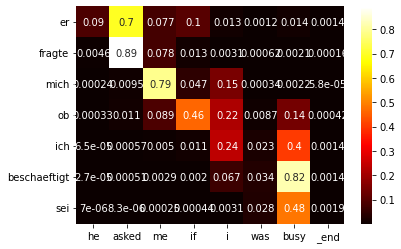

In [128]:
predict_random_val_sentence()

Input: i hope no one sees us 
Predicted translation: ich hoffe wir sehe uns 
Actual translation: ich hoffe dass uns niemand sieht


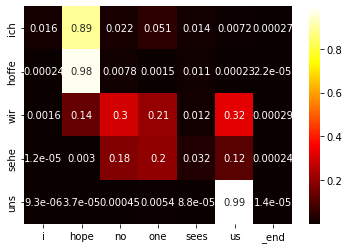

In [129]:
predict_random_val_sentence()

Input: the nights are getting shorter 
Predicted translation: die naechte werden kuerzer 
Actual translation: die naechte werden kuerzer


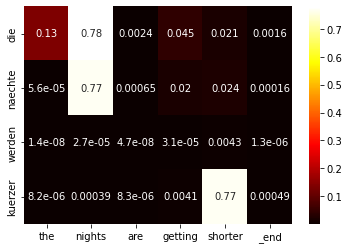

In [130]:
predict_random_val_sentence()

Input: she helped him tie his tie 
Predicted translation: sie hat ihn ihrem chef und krawatte zu binden 
Actual translation: sie half ihm seine krawatte zu binden


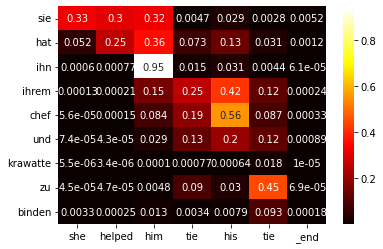

In [131]:
predict_random_val_sentence()

Input: tom imitated mary 
Predicted translation: tom ahmte maria 
Actual translation: tom ahmte maria nach


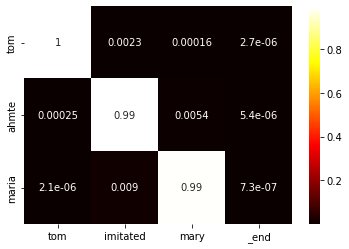

In [ ]:
predict_random_val_sentence()

Input: ill get the ladder 
Predicted translation: ich werde den weg 
Actual translation: ich hole die leiter


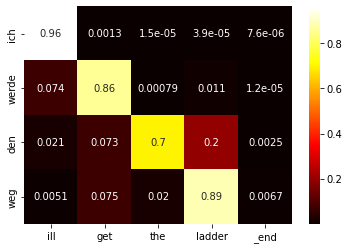

In [ ]:
predict_random_val_sentence()

Input: she is ethiopian 
Predicted translation: sie ist aethiopierin 
Actual translation: sie ist aethiopierin


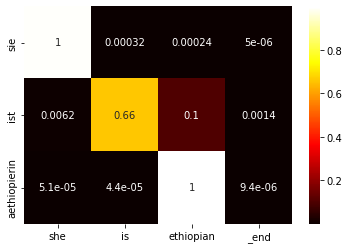

In [ ]:
predict_random_val_sentence()